In [149]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import os
import warnings
import matplotlib.pyplot as plt 
import keras

In [150]:
#예측하려는 삼성 주가 데이터 csv 파일을 판다스를 이용해서 불러온다
samsung = pd.read_csv('삼성3.csv') 

In [151]:
#데이터를 정규화해주기 위한 min_max sclaer 함수
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) 

In [152]:
#정규화된 예측값을 역정규화해주기 위한 inverse scaling 함수
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [153]:
samsung.head()

,Date,Open,High,Low,Close,12-day ema,26-day ema,MACD,Volume
0,00-01-04,6000,6110,5660,6110,NaN,NaN,NaN,74195000.0
1,00-01-05,5800,6060,5520,5580,NaN,NaN,NaN,74680000.0
2,00-01-06,5750,5780,5580,5620,NaN,NaN,NaN,54390000.0
3,00-01-07,5560,5670,5360,5540,NaN,NaN,NaN,40305000.0
4,00-01-10,5600,5770,5580,5770,NaN,NaN,NaN,46880000.0


In [154]:
#예측에 사용하지 않을 ema data부분을 삭제한다
del samsung['12-day ema']
del samsung['26-day ema']

In [155]:
#0행부터 23행까지의 데이터에는 NAN이 포함되어 있으므로 데이터셋에서 제외시켜준다
for i in range(0,24):
    samsung.drop([i],axis = 'rows',inplace = True)    

In [156]:
samsung.head()

,Date,Open,High,Low,Close,MACD,Volume
24,00-02-08,5340,5480,5310,5430,5013.554796,58460000.0
25,00-02-09,5560,5720,5480,5720,5073.230262,51050000.0
26,00-02-10,5660,5880,5600,5760,5114.508874,61845000.0
27,00-02-11,5960,5960,5680,5700,5148.340026,34660000.0
28,00-02-14,5600,5660,5340,5380,5147.052953,44140000.0


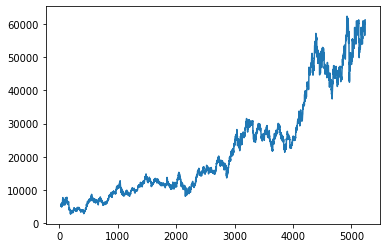

In [157]:
plt.plot(samsung.Close)

In [158]:
del samsung['Date']
samsung.head()

,Open,High,Low,Close,MACD,Volume
24,5340,5480,5310,5430,5013.554796,58460000.0
25,5560,5720,5480,5720,5073.230262,51050000.0
26,5660,5880,5600,5760,5114.508874,61845000.0
27,5960,5960,5680,5700,5148.340026,34660000.0
28,5600,5660,5340,5380,5147.052953,44140000.0


In [159]:
#새로운 열 Close tmr을 추가하여, 내일의 종가를 입력한다 -> 프로젝트의 목표인 다음날 종가 예측을 위한 전처리 과정
samsung["Close tmr"] = samsung.Close.shift(-1)
samsung

,Open,High,Low,Close,MACD,Volume,Close tmr
24,5340,5480,5310,5430,5013.554796,5.846000e+07,5720.0
25,5560,5720,5480,5720,5073.230262,5.105000e+07,5760.0
26,5660,5880,5600,5760,5114.508874,6.184500e+07,5700.0
27,5960,5960,5680,5700,5148.340026,3.466000e+07,5380.0
28,5600,5660,5340,5380,5147.052953,4.414000e+07,5200.0
...,...,...,...,...,...,...,...
5230,59000,60300,58800,60300,4157.306596,5.489223e+04,60100.0
5231,60700,60800,59600,60100,4132.059037,5.507908e+04,60200.0
5232,60700,60900,60100,60200,4141.408564,5.522187e+04,60200.0
5233,60500,60500,59500,60200,4140.689370,5.535131e+04,61300.0


In [160]:
#마지막 행 NAN으로 인한 삭제
samsung.drop([5234],axis = 'rows',inplace =True)

In [161]:
#initial data를 유지하면서 data를 조작하기 위해 새로운 dataframe에 기존 data를 copy한다.
samsung_new = samsung.copy()

In [162]:
samsung_new

,Open,High,Low,Close,MACD,Volume,Close tmr
24,5340,5480,5310,5430,5013.554796,5.846000e+07,5720.0
25,5560,5720,5480,5720,5073.230262,5.105000e+07,5760.0
26,5660,5880,5600,5760,5114.508874,6.184500e+07,5700.0
27,5960,5960,5680,5700,5148.340026,3.466000e+07,5380.0
28,5600,5660,5340,5380,5147.052953,4.414000e+07,5200.0
...,...,...,...,...,...,...,...
5229,58900,59000,57800,58500,4021.680924,5.480049e+04,60300.0
5230,59000,60300,58800,60300,4157.306596,5.489223e+04,60100.0
5231,60700,60800,59600,60100,4132.059037,5.507908e+04,60200.0
5232,60700,60900,60100,60200,4141.408564,5.522187e+04,60200.0


In [163]:
indicator = samsung_new.iloc[:,:-2] #Close tmr을 예측하기 위한 보조지표 Open ~ MACD 열까지를 설정
norm_indicator = min_max_scaling(indicator) # 지표 데이터 정규화 처리
print("indicator.shape: ", indicator.shape)
print("norm_indicator[0]: ", norm_indicator[0])

indicator.shape:  (5210, 5)
norm_indicator[0]:  [0.08136308 0.08360132 0.08088346 0.08280195 0.07614407]


In [164]:
volume = samsung_new.iloc[:,-2:-1]

norm_volume = min_max_scaling(volume) # VOLUME 데이터 정규화 처리 _ Volume의 크기가 다른 지표들에 비해 비약적으로 크기 때문에, 따로 정규화를 진행한다.

print("volume.shape: ", volume.shape)
print("norm_volume[0]: ", norm_volume[0])

volume.shape:  (5210, 1)
norm_volume[0]:  [0.35588826]


In [165]:
target = samsung_new.iloc[:,-1:] #Close tmr 값을 target으로 지정해준다

norm_target = min_max_scaling(target) # target 데이터 정규화 처리

print("target.shape: ", target.shape)
print("norm_target[0]: ", norm_target[0])

target.shape:  (5210, 1)
norm_target[0]:  [0.05010893]


In [166]:
x = np.concatenate((norm_indicator, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = norm_target # 타켓은 내일 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

x.shape:  (5210, 6)
x[0]:  [0.08136308 0.08360132 0.08088346 0.08280195 0.07614407 0.35588826]
x[-1]:  [9.63228943e-01 9.63228943e-01 9.47241527e-01 9.58432719e-01
 6.21892038e-02 1.68717702e-04]
y[0]:  [0.05010893]
y[-1]:  [0.98156528]


In [167]:
#정규화 한 값들을 바탕으로 새로운 데이터프레임 samsung_new2를 생성한다
samsung_new2 = pd.DataFrame(x, columns=list(['Open','High','Low','Close','MACD','Volume']))
samsung_new2

,Open,High,Low,Close,MACD,Volume
0,0.081363,0.083601,0.080883,0.082802,0.076144,0.355888
1,0.084880,0.087438,0.083601,0.087438,0.077098,0.310757
2,0.086479,0.089996,0.085520,0.088078,0.077758,0.376505
3,0.091275,0.091275,0.086799,0.087119,0.078299,0.210932
4,0.085520,0.086479,0.081363,0.082003,0.078278,0.268671
...,...,...,...,...,...,...
5205,0.937649,0.939248,0.920063,0.931254,0.060287,0.000165
5206,0.939248,0.960031,0.936050,0.960031,0.062455,0.000166
5207,0.966426,0.968025,0.948840,0.956834,0.062051,0.000167
5208,0.966426,0.969624,0.956834,0.958433,0.062201,0.000168


In [168]:
#위에서 만들어준 데이터프레임에 target 열을 추가한다
samsung_new2['target']=y
samsung_new2

,Open,High,Low,Close,MACD,Volume,target
0,0.081363,0.083601,0.080883,0.082802,0.076144,0.355888,0.050109
1,0.084880,0.087438,0.083601,0.087438,0.077098,0.310757,0.050779
2,0.086479,0.089996,0.085520,0.088078,0.077758,0.376505,0.049774
3,0.091275,0.091275,0.086799,0.087119,0.078299,0.210932,0.044411
4,0.085520,0.086479,0.081363,0.082003,0.078278,0.268671,0.041394
...,...,...,...,...,...,...,...
5205,0.937649,0.939248,0.920063,0.931254,0.060287,0.000165,0.964806
5206,0.939248,0.960031,0.936050,0.960031,0.062455,0.000166,0.961455
5207,0.966426,0.968025,0.948840,0.956834,0.062051,0.000167,0.963131
5208,0.966426,0.969624,0.956834,0.958433,0.062201,0.000168,0.963131


In [169]:
TEST_SIZE = 1500 #총 5210개의 데이터 중 마지막 1500개를 테스트데이터로 사용한다
train = samsung_new2[:-TEST_SIZE]
test = samsung_new2[-TEST_SIZE:]

def make_dataset(data, label, window_size): #Window 갯수에 따라 데이터셋을 만드는 함수
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [170]:
indicator_cols = ['Open', 'High', 'Low','Close','Volume'] #indicator 부분 지정 #MACD 제외
label_cols = ['target'] #target(Closing Price of tomorrow) 지정

train_indicator = train[indicator_cols]
train_label = train[label_cols]

train_indicator, train_label = make_dataset(train_indicator,train_label,30) #설정한 window값(=30)으로 훈련 데이터셋을 만들어준다
train_indicator.shape, train_label.shape

((3680, 30, 5), (3680, 1))

In [171]:
test_indicator = test[indicator_cols]
test_label = test[label_cols]

test_indicator, test_label = make_dataset(test_indicator,test_label,30) #설정한 window값(=30)으로 테스트 데이터셋을 만들어준다
test_indicator.shape, test_label.shape

((1470, 30, 5), (1470, 1))

In [172]:
#데이터셋이 올바르게 설정되었는지 확인해본다
x1_train = train_indicator
x1_test = test_indicator
y1_train = train_label
y1_test = test_label

print(x1_train.shape)
print(x1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(3680, 30, 5)
(1470, 30, 5)
(3680, 1)
(1470, 1)


In [173]:
# LSTM Model
from keras.models import Model
from keras.layers import Dense, LSTM, Input

# model 1
input1 = Input(shape=(x1_train.shape[1],x1_train.shape[2]))
dense1 = LSTM(256, activation ='relu')(input1)
dense1 = Dense(64)(dense1)
dense1 = Dense(32)(dense1)
output1 = Dense(1)(dense1)

model = Model(inputs = input1, outputs = output1)
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 30, 5)]           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dense_36 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 286,849
Trainable params: 286,849
Non-trainable params: 0
_________________________________________________________________


In [174]:
#MSE를 Loss함수로 하여 컴파일한다
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20)
model.fit(x1_train, y1_train, epochs=70, batch_size=100, validation_split=0, callbacks=[early_stopping])

loss, mse = model.evaluate(x1_test, y1_test, batch_size=1)
print('loss:', loss)

Epoch 1/70
37/37 [==============================] - 3s 75ms/step - loss: 0.0069 - mse: 0.0069
Epoch 2/70
37/37 [==============================] - 3s 76ms/step - loss: 1.4987e-04 - mse: 1.4987e-04
Epoch 3/70
37/37 [==============================] - 3s 75ms/step - loss: 1.0217e-04 - mse: 1.0217e-04
Epoch 4/70
37/37 [==============================] - 3s 76ms/step - loss: 9.0893e-05 - mse: 9.0893e-05
Epoch 5/70
37/37 [==============================] - 3s 79ms/step - loss: 8.5823e-05 - mse: 8.5823e-05
Epoch 6/70
37/37 [==============================] - 3s 84ms/step - loss: 8.1804e-05 - mse: 8.1804e-05
Epoch 7/70
37/37 [==============================] - 4s 107ms/step - loss: 7.9533e-05 - mse: 7.9533e-05
Epoch 8/70
37/37 [==============================] - 4s 103ms/step - loss: 7.7379e-05 - mse: 7.7379e-05
Epoch 9/70
37/37 [==============================] - 3s 85ms/step - loss: 7.7592e-05 - mse: 7.7592e-05
Epoch 10/70
37/37 [==============================] - 3s 75ms/step - loss: 7.7665e-05 - m

In [175]:
#예측값과 실제값에 대한 array real, forecast 생성
y_pred = model.predict(x1_test)
real = np.concatenate((y1_train,y1_test))
forecast = np.concatenate((y1_train,y_pred1))

In [176]:
real
forecast

array([[0.05815318],
       [0.06820848],
       [0.06820848],
       ...,
       [0.9498077 ],
       [0.95790249],
       [0.96140385]])

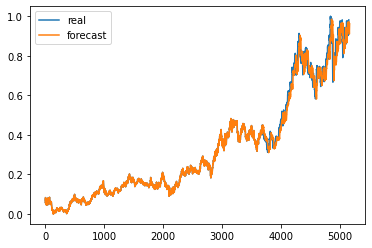

In [177]:
#Plot real & forecast
plt.plot(real, label='real')
plt.plot(forecast, label='forecast')
plt.legend()

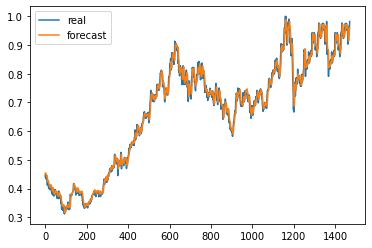

In [178]:
#예측한 부분만 추출하여 보기
plt.plot(y1_test, label='real')
plt.plot(y_pred, label='forecast')
plt.legend()

In [179]:
#예측한 값을 inverse scaling을 통해 원 단위로 바꿔준다
forecast = reverse_min_max_scaling(target, y_pred)
real = reverse_min_max_scaling(target, y1_test)

forecast

array([[29856.074],
       [29856.607],
       [29828.197],
       ...,
       [58845.586],
       [59563.465],
       [60040.938]], dtype=float32)

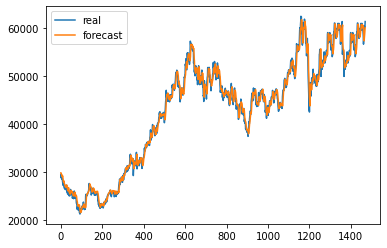

In [180]:
plt.plot(real, label='real')
plt.plot(forecast, label='forecast')

plt.legend()